This Notebook is intended to bring us through an entire experiment.
- Previous to this Notebook we will explore setting up an Azure KeyVault Back Secret Scope
- Reviewing the existing Databricks environment
- Leveraging an external notebook with our secret scopes (updating a class to reflect what currently is marked as secret scopes)
- Importing data into databricks
- Reading csv into Spark Dataframe & Pandas Dataframe
- Adding columns to Spark Dataframe
- Adding columns to Pandas Dataframe
- Creating Tables
- Creating plots for analysis
- sklearn's RandomForestClassifier returns a binary classification (0 or 1)
- Registering a model
- xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials
- Archiving Model and moving previous model to archive
- Registering Model in Azure ML and Deploying to AKS Cluster

In [2]:
user_name = 'mega'

In [3]:
user_id = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
print(user_id)

memasanz@goldgovdomain.onmicrosoft.us

Lets view what is in dbfs (Databricks File System)

In [5]:
display(dbutils.fs.ls('dbfs:/'))

path,name,size
dbfs:/FileStore/,FileStore/,0
dbfs:/databricks-datasets/,databricks-datasets/,0
dbfs:/databricks-results/,databricks-results/,0
dbfs:/mnt/,mnt/,0
dbfs:/tmp/,tmp/,0
dbfs:/user/,user/,0


### Review what has currently been mounted

In [7]:
try:
  display(dbutils.fs.ls('dbfs:/mnt/'))
except Exception as e:
  if 'FileNotFoundException' in str(e):
    print("haven't mounted anything yet")
  else:
      print(e)
      pass

path,name,size
dbfs:/mnt/container01/,container01/,0
dbfs:/mnt/raw-container02/,raw-container02/,0


This Helper Function Below we will need to update based on the secrets in key-vault.

In [9]:
%run "/HelperFunctions/HelperFunctions"

This helper class is not required to work given the data mounts have already been created, but it is a good practice

In [11]:
utils = Helper()
#provide the utility a databricks secret scope
utils.get_secrets('mm-keyvault')

storage_mount_container = "container01"
storage_mount_point = "/mnt/container01/"
utils.mount_drive(storage_mount_container, storage_mount_point)

#Example mount to a directory inside a container
storage_mount_container = "container02"
storage_mount_directory = "raw"
storage_mount_point = "/mnt/raw-container02/"
utils.mount_directory(storage_mount_container, storage_mount_directory, storage_mount_point)

mm-keyvault
mount drive for:container01mount_point:/mnt/container01/
Directory already mounted
mount drive for:container02mount_point:/mnt/raw-container02/
Directory already mounted

In [12]:
dbutils.fs.ls('dbfs:/mnt/')

Out[7]: [FileInfo(path='dbfs:/mnt/container01/', name='container01/', size=0),
 FileInfo(path='dbfs:/mnt/raw-container02/', name='raw-container02/', size=0)]

In [13]:
data = list(map(lambda x: x.path, dbutils.fs.ls(storage_mount_point)))
print(data)

['dbfs:/mnt/raw-container02/ds-prepped (2).csv']

## Importing Data
  
In this section, you download a dataset from the web and upload it to Databricks File System (DBFS). It is actually already included in the download of the repo - under the data folder, but you can go and grab it as well

1. Navigate to https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ and download both `winequality-red.csv` and `winequality-white.csv` to your local machine.

1. From this Databricks notebook, select *File* > *Upload Data*, and drag these files to the drag-and-drop target to upload them to the Databricks File System (DBFS). 

    **Note**: if you don't have the *File* > *Upload Data* option, you can load the dataset from the Databricks example datasets. Uncomment and run the last two lines in the following cell.

1. Click *Next*. Some auto-generated code to load the data appears. Select *pandas*, and copy the example code. 

1. Create a new cell, then paste in the sample code. It will look similar to the code shown in the following cell. Make these changes:
  - Pass `sep=';'` to `pd.read_csv`
  - Change the variable names from `df1` and `df2` to `white_wine` and `red_wine`, as shown in the following cell.

In [15]:
try:
  display(dbutils.fs.ls('dbfs:/FileStore/shared_uploads/'))
except Exception as e:
  if 'FileNotFoundException' in str(e):
    print("Import the Data using File -> Upload Data")
  else:
      print(e)
      pass

path,name,size
dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/,memasanz@goldgovdomain.onmicrosoft.us/,0


In [16]:
display(dbutils.fs.ls('dbfs:/FileStore/shared_uploads/' + user_id))

path,name,size
dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_red.csv,winequality_red.csv,85799
dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_white.csv,winequality_white.csv,269325


In [17]:
import pandas as pd
 
# In the following lines, replace <username> with your username.
white_wine = pd.read_csv("/dbfs/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_white.csv", sep=';')
red_wine = pd.read_csv("/dbfs/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_red.csv", sep=';')

df_bad = spark.read.format("csv").load("dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_red.csv")

file_white = "dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_white.csv"
file_red = "dbfs:/FileStore/shared_uploads/memasanz@goldgovdomain.onmicrosoft.us/winequality_red.csv"
df_white = spark.read.format("csv").option("header","true").option("inferSchema", "true").option("sep", ";").load(file_white)
df_red = spark.read.format("csv").option("header","true").option("inferSchema", "true").option("sep", ";").load(file_red)

print(red_wine.shape)
print(white_wine.shape)
print('---------------------------')
print((df_red.count(), (len(df_red.columns))))
print((df_white.count(), (len(df_white.columns))))

(1599, 12)
(4898, 12)
---------------------------
(1599, 12)
(4898, 12)

Syntax matter - note the reading from **df_bad** will put it all into 1 column

In [19]:
display(df_bad)

_c0
"""fixed acidity"";""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


check out a good Spark dataframe.  We have 2 of them and want to be able to identify when something is red, and when something is white

In [21]:
display(df_red)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.0,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
7.9,0.6,0.06,1.6,0.069,15.0,59.0,0.9964,3.3,0.46,9.4,5
7.3,0.65,0.0,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
7.5,0.5,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.8,10.5,5


In [22]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

df_red = df_red.withColumn('is_red', lit(True))
df_white = df_white.withColumn('is_red', lit(False))

print((df_red.count(), (len(df_red.columns))))
print((df_white.count(), (len(df_white.columns))))

(1599, 13)
(4898, 13)

we can union them together

In [24]:
df_all = df_white.union(df_red);
print((df_all.count(), (len(df_all.columns))))

(6497, 13)

In [25]:
display(df_all.describe())

summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497
mean,7.21530706479913,0.33966599969216654,0.31863321533014727,5.44323533938742,0.05603386178236105,30.525319378174544,115.7445744189626,0.9946966338309939,3.2185008465445577,0.5312682776666166,10.491800831152862,5.818377712790519
stddev,1.296433757799814,0.16463647408467896,0.14531786489759146,4.7578037431474165,0.03503360137245908,17.7493997720025,56.52185452263029,0.0029986730037191403,0.16078720210398784,0.14880587361449052,1.1927117488709942,0.8732552715311255
min,3.8,0.08,0.0,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3
max,15.9,1.58,1.66,65.8,0.611,289.0,440.0,1.03898,4.01,2.0,14.9,9


In [26]:
import pyspark.sql.functions as fn
df_temp = df_all.withColumn('new_id', fn.monotonically_increasing_id())
display(df_temp)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red,new_id
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,false,0
6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,false,1
8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,false,2
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6,false,3
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6,false,4
8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,false,5
6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,false,6
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,false,7
6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,false,8
8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6,false,9


In [27]:
df_temp.groupby('quality').count().show()

+-------+-----+
quality|count|
+-------+-----+
 6| 2836|
 3| 30|
 5| 2138|
 9| 5|
 4| 216|
 8| 193|
 7| 1079|
+-------+-----+

Here is an example of levering a udf, not needed for our experiment, but wanted to include

<https://databricks.com/blog/2020/05/20/new-pandas-udfs-and-python-type-hints-in-the-upcoming-release-of-apache-spark-3-0.html>

In [29]:
from pyspark.sql.types import DoubleType
def squared(s):
  return s * s

udf_squared = udf(squared, DoubleType())

@udf("double")
def udf_squared2(s):
  return s* s

@udf("string")
def udf_str(s):
  return "hello " + str(s)

Below is an example of leveraging the udf created above

In [31]:
df_temp = df_all.withColumn("new_col", udf_squared('alcohol')).withColumn("new_col2", udf_squared2('alcohol')).withColumn('new_col3', udf_str('quality'))
display(df_temp)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red,new_col,new_col2,new_col3
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,false,77.44000000000001,77.44000000000001,hello 6
6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,false,90.25,90.25,hello 6
8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,false,102.00999999999999,102.00999999999999,hello 6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6,false,98.01,98.01,hello 6
7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.4,9.9,6,false,98.01,98.01,hello 6
8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6,false,102.00999999999999,102.00999999999999,hello 6
6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,false,92.16,92.16,hello 6
7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,false,77.44000000000001,77.44000000000001,hello 6
6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6,false,90.25,90.25,hello 6
8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6,false,121.0,121.0,hello 6


Its nice to be able to save your data.  I recommend having your own database when it is something that you are not ready to share, you can switch to SQL to create a database, but it won't be just for you.  It will be for everyone.  Not ideal

In [33]:
%sql
CREATE DATABASE IF NOT EXISTS sample_data;
USE sample_data;

The sample code below will create an new database that you can save your tables to

In [35]:
param = user_name
query = "CREATE DATABASE IF NOT EXISTS sample_data_{}".format(param)
sqlContext.sql(query)

query = "USE sample_data_{}".format(param)
sqlContext.sql(query)

Out[60]: DataFrame[]

Below are 2 functions, one that will allow us to quickly append to a table, and one that will allow us to rename columns to remove the spaces

In [37]:
def col_rename(df):
  cols = []
  cols_alias = []
  cols_check = []
  cols = df.columns
  i = 0
  
  cols_to_replace = []
  for x in cols:
    print(x)
    if (' ' in x) or ('.' in x) or ('+' in x) or ('(' in x) or (')' in x):
      cols_to_replace.append(x)
      
  col_number = len(cols_to_replace)
  
  for x in cols_to_replace:
    i = i + 1
    df = df.withColumnRenamed(x,x.replace(" ", "_").replace(".", "_").replace("+","").replace("(","").replace(")",""))
  return df

def append_table(df, tablename):
  df.write.mode('append').saveAsTable(tablename)
  print('Table Appended to')

In [38]:
df_all = col_rename(df_all)
df_all.write.mode('overwrite').saveAsTable('full_dataset_wine_data')

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality
is_red

Pandas dataframes display as expected in a notebook experience

In [40]:
white_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Here we can save a new value to the pandas dataframe

In [42]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0
#axis = 0 : rows
data = pd.concat([red_wine, white_wine], axis=0)
 
# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [43]:
print(red_wine.shape)
print(white_wine.shape)
print(data.shape)

(1599, 13)
(4898, 13)
(6497, 13)

##Data Visualization

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

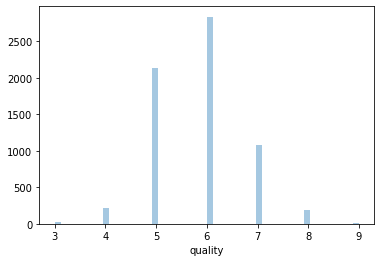

In [45]:
import seaborn as sns
sns.distplot(data.quality, kde=False)

In [46]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality
data.shape

Out[67]: (6497, 13)

Box plots are useful in noticing correlations between features and a binary label.

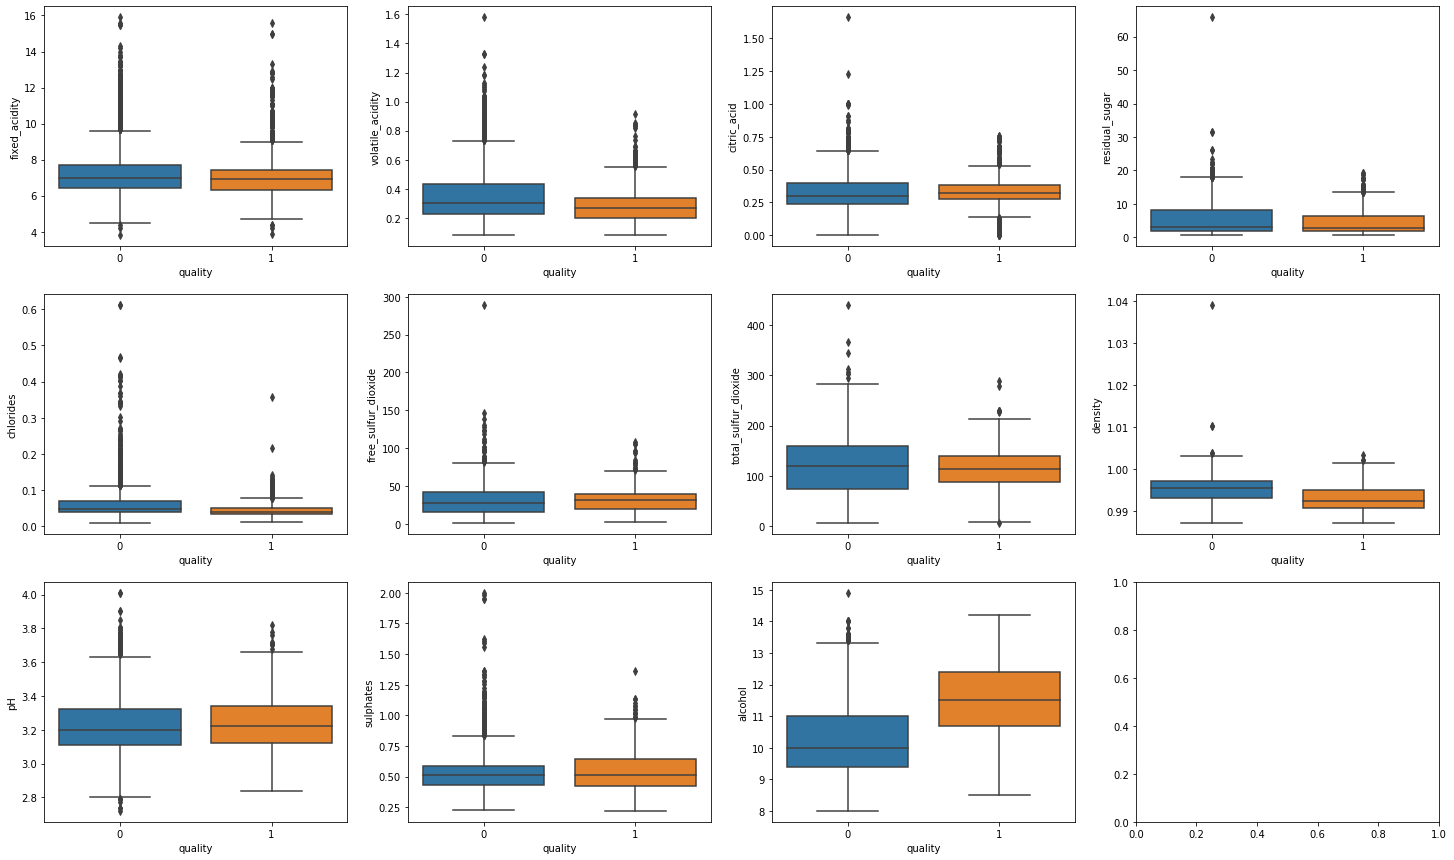

In [48]:
import matplotlib.pyplot as plt
 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocessing Data
Prior to training a model, check for missing values and split the data into training and validation sets.

In [51]:
data.isna().any()

Out[69]: fixed_acidity False
volatile_acidity False
citric_acid False
residual_sugar False
chlorides False
free_sulfur_dioxide False
total_sulfur_dioxide False
density False
pH False
sulphates False
alcohol False
quality False
is_red False
dtype: bool

Split out into train and test dataset.

In [53]:
from sklearn.model_selection import train_test_split
 
train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

## Building a Baseline Model

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

https://mlflow.org/docs/latest/python_api/mlflow.pyfunc.html

In [55]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import mlflow.models
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models import infer_signature

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

When an mlflow run is started, if there is not an active expereiment, one will be created, and it will default to be scoped for the notebook.

So this is using the wrapper, and it able to infer the signture https://mlflow.org/docs/latest/python_api/mlflow.models.html#mlflow.models.infer_signature and returns a model signture.  Then when you log the model you are able to provide the signautre

In [57]:


# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  print("Model saved in run %s" % mlflow.active_run().info.run_uuid)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, signature=signature)
  #mlflow.sklearn.log_model(lr, "model")
  print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

Model saved in run e9516513d830449884286e958b7aad9f
Model saved in run e9516513d830449884286e958b7aad9f

Examine the learned feature importances output by the model as a sanity-check.

In [59]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.162047
density,0.115506
volatile_acidity,0.089138
chlorides,0.082570
pH,0.081632
citric_acid,0.081109
total_sulfur_dioxide,0.081001
sulphates,0.078901
residual_sugar,0.077866
free_sulfur_dioxide,0.076833


As illustrated by the boxplots shown previously, both alcohol and density are important in predicting quality.

Check out the experiment tab.

You logged the Area Under the ROC Curve (AUC) to MLflow. Click **Experiment** at the upper right to display the Experiment Runs sidebar. 

The model achieved an AUC of 0.89. 

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

#### Registering the model in the MLflow Model Registry

By registering this model in the Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI by following the steps in [Register a model in the Model Registry
](https://docs.microsoft.com/azure/databricks/applications/mlflow/model-registry).

In [64]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id
print(run_id)

e9516513d830449884286e958b7aad9f

In [65]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = user_name + "wine_quality"

model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

Successfully registered model 'megawine_quality'.
Created version '1' of model 'megawine_quality'.

Now that model has been registered.  We can move it into production

In [67]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[32]: <ModelVersion: creation_timestamp=1604436834318, current_stage='Production', description='', last_updated_timestamp=1604436838411, name='', run_id='e9516513d830449884286e958b7aad9f', run_link='', source='dbfs:/databricks/mlflow-tracking/1168969930051397/e9516513d830449884286e958b7aad9f/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='2375681286445317', version='1'>

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine-quality/production".

We can check the score: 
<https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc>

In [69]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.888902759745664

##Experimenting with a new model

The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple
models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

<http://hyperopt.github.io/hyperopt/scaleout/spark/>

Databricks Runtime for Machine Learning includes Hyperopt, augmented with an implementation powered by Apache Spark. By using the SparkTrials extension of hyperopt.Trials, you can easily distribute a Hyperopt run without making other changes to your Hyperopt usage. When applying the hyperopt.fmin() function, you pass in the SparkTrials class. SparkTrials can accelerate single-machine tuning by distributing trials to Spark workers.

Also note here we are using ml flow auto logging. Auto logging captures metrics, parameters, and artifacts.

<https://www.mlflow.org/docs/latest/python_api/mlflow.xgboost.html>

In [71]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials, 
    rstate=np.random.RandomState(123)
  )

/databricks/python/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 from imp import reload
Parallelism (10) is greater than the current total of Spark task slots (4). If dynamic allocation is enabled, you might see more executors allocated.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/96 [00:00<?, ?trial/s, best loss=?] 1%| | 1/96 [00:17<27:10, 17.16s/trial, best loss: -0.9129512586019128] 2%|▏ | 2/96 [00:18<19:17, 12.32s/trial, best loss: -0.9129512586019128] 3%|▎ | 3/96 [00:24<16:11, 10.45s/trial, best loss: -0.9148987268931341] 4%|▍ | 4/96 [00:26<12:08, 7.91s/trial, best loss: -0.9148987268931341] 5%|▌ | 5/96 [00:30<10:15, 6.77s/trial, best loss: -0.9173717025010343] 6%|▋ | 6/96 [00:31<07:33, 5.04s/trial, best loss: -0.9173717025010343] 7%|▋ | 7/96 [00:37<07:54, 5.33s/trial, best loss: -0.9173717025010343] 8%|▊ | 8/96 [00:43<08:06, 5.53s/trial, best loss: -0.9173717025010343] 9%|▉ | 9/96 [00:44<06:05, 4.20s/trial, best loss: -0.9184108278285847] 10%|█ | 10/96 [00:46<05:04, 3.54s/trial, best loss: -0.9184108278285847] 11%|█▏ | 11/96 [00:52<06:04, 4.29s/trial, best loss: -0.9184108278285847] 12%|█▎ | 12/96 [00:56<05:53, 4.21s/trial, best loss: -0.9184108278285847] 15%|█▍ | 14/96 [01:06<06:04, 4.45s/trial, best loss: -0.9184108278285847] 16%|█▌ | 15/96 [01:16<08:16, 6.13s/trial, best loss: -0.9184108278285847] 17%|█▋ | 16/96 [01:23<08:31, 6.40s/trial, best loss: -0.9184108278285847] 18%|█▊ | 17/96 [01:24<06:17, 4.78s/trial, best loss: -0.9184108278285847] 19%|█▉ | 18/96 [01:32<07:30, 5.78s/trial, best loss: -0.9214663794210385] 20%|█▉ | 19/96 [01:33<05:36, 4.37s/trial, best loss: -0.9233948248229682] 21%|██ | 20/96 [01:44<08:04, 6.37s/trial, best loss: -0.9233948248229682] 22%|██▏ | 21/96 [01:52<08:35, 6.87s/trial, best loss: -0.9233948248229682] 23%|██▎ | 22/96 [01:54<06:40, 5.41s/trial, best loss: -0.9233948248229682] 25%|██▌ | 24/96 [01:58<05:16, 4.39s/trial, best loss: -0.9233948248229682] 26%|██▌ | 25/96 [02:12<08:37, 7.29s/trial, best loss: -0.9233948248229682] 27%|██▋ | 26/96 [02:13<06:18, 5.40s/trial, best loss: -0.9233948248229682] 28%|██▊ | 27/96 [02:16<05:23, 4.69s/trial, best loss: -0.9233948248229682] 29%|██▉ | 28/96 [02:22<05:25, 4.79s/trial, best loss: -0.9233948248229682] 30%|███ | 29/96 [02:27<05:25, 4.86s/trial, best loss: -0.9233948248229682] 31%|███▏ | 30/96 [02:36<06:43, 6.11s/trial, best loss: -0.9233948248229682] 32%|███▏ | 31/96 [02:37<04:57, 4.58s/trial, best loss: -0.9233948248229682] 33%|███▎ | 32/96 [02:44<05:40, 5.32s/trial, best loss: -0.9233948248229682] 34%|███▍ | 33/96 [02:50<05:48, 5.53s/trial, best loss: -0.9233948248229682] 35%|███▌ | 34/96 [02:52<04:37, 4.48s/trial, best loss: -0.9233948248229682] 36%|███▋ | 35/96 [02:55<04:06, 4.04s/trial, best loss: -0.9233948248229682] 38%|███▊ | 36/96 [03:02<04:56, 4.94s/trial, best loss: -0.9233948248229682] 39%|███▊ | 37/96 [03:09<05:28, 5.56s/trial, best loss: -0.9233948248229682] 40%|███▉ | 38/96 [03:16<05:48, 6.00s/trial, best loss: -0.9233948248229682] 41%|████ | 39/96 [03:18<04:34, 4.81s/trial, best loss: -0.9233948248229682] 42%|████▏ | 40/96 [03:23<04:32, 4.87s/trial, best loss: -0.9233948248229682] 43%|████▎ | 41/96 [03:27<04:13, 4.62s/trial, best loss: -0.9233948248229682] 44%|████▍ | 42/96 [03:33<04:32, 5.04s/trial, best loss: -0.9233948248229682] 46%|████▌ | 44/96 [03:43<04:21, 5.03s/trial, best loss: -0.923394824822

#### Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.91. You beat the baseline!

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon <img src="https://docs.microsoft.com/azure/databricks/_static/images/external-link.png"/> at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

Now investigate how the hyperparameter choice correlates with AUC. Click the "+" icon to expand the parent run, then select all runs except the parent, and click "Compare". Select the Parallel Coordinates Plot.

The Parallel Coordinates Plot is useful in understanding the impact of parameters on a metric. You can drag the pink slider bar at the upper right corner of the plot to highlight a subset of AUC values and the corresponding parameter values. The plot below highlights the highest AUC values:

<img src="https://docs.microsoft.com/azure/databricks/_static/images/mlflow/end-to-end-example/parallel-coordinates-plot.png"/>

Notice that all of the top performing runs have a low value for reg_lambda and learning_rate. 

You could run another hyperparameter sweep to explore even lower values for these parameters. For simplicity, that step is not included in this example.

You used MLflow to log the model produced by each hyperparameter configuration. The following code finds the best performing run and saves the model to the model registry.

In [75]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9233948248229682

#### Updating the production wine_quality model in the MLflow Model Registry

Earlier, you saved the baseline model to the Model Registry under "wine_quality". Now that you have a created a more accurate model, update wine_quality.

In [77]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

Registered model 'megawine_quality' already exists. Creating a new version of this model...
Created version '2' of model 'megawine_quality'.

Click **Models** in the left sidebar to see that the wine_quality model now has two versions. 

The following code promotes the new version to production.

In [79]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived",
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production",
)

Out[37]: <ModelVersion: creation_timestamp=1604437327961, current_stage='Production', description='', last_updated_timestamp=1604437335233, name='', run_id='299960208dac415d806fc1838fb39681', run_link='', source='dbfs:/databricks/mlflow-tracking/1168969930051397/299960208dac415d806fc1838fb39681/artifacts/model', status='READY', status_message='', tags={}, user_id='2375681286445317', version='2'>

Clients that call load_model now receive the new model.

In [81]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9233948248229682

##Batch Inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

The following code evaluates the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [83]:
dbutils.fs.ls('dbfs:/mnt/')

Out[39]: [FileInfo(path='dbfs:/mnt/container01/', name='container01/', size=0),
 FileInfo(path='dbfs:/mnt/raw-container02/', name='raw-container02/', size=0)]

### Best Practices for levering a delta lake table.

<https://kb.databricks.com/delta/drop-delta-table.html#:~:text=If%20a%20Delta%20table%20has%20been%20in%20use,a%20notebook%20cell.%20Click%20Delete%20in%20the%20UI>

In [85]:
#tableName = 'wine_data_inference'
#spark.sql(f'DELETE FROM sample_data_{user_name}.{tableName}') 


In [86]:
#spark.sql(f'VACUUM sample_data_{user_name}.{tableName}') 

In [87]:
#spark.sql(f'DROP TABLE IF EXISTS sample_data_{user_name}.{tableName}')

In [88]:
X_test

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red
1321,5.0,0.74,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,1
1168,7.2,0.20,0.38,1.00,0.037,21.0,74.0,0.99180,3.21,0.37,11.0,0
3470,6.7,0.24,0.30,3.85,0.042,105.0,179.0,0.99189,3.04,0.59,11.3,0
4181,6.6,0.25,0.32,5.60,0.039,15.0,68.0,0.99163,2.96,0.52,11.1,0
547,10.6,0.31,0.49,2.50,0.067,6.0,21.0,0.99870,3.26,0.86,10.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1839,7.0,0.19,0.23,5.70,0.123,27.0,104.0,0.99540,3.04,0.54,9.4,0
2333,6.8,0.37,0.28,1.90,0.024,64.0,106.0,0.98993,3.45,0.60,12.6,0
2962,6.9,0.38,0.38,13.10,0.112,14.0,94.0,0.99792,3.02,0.48,9.2,0
1302,9.1,0.37,0.32,2.10,0.064,4.0,15.0,0.99576,3.30,0.80,11.2,1


In [89]:
# Be sure to update the write path here.

df = spark.createDataFrame(X_test)

writePath = "dbfs:/mnt/container01/" + user_name
tableName = 'wine_data_inference'

#dbutils.fs.rm(writePath, True)

spark.sql(f'DROP TABLE IF EXISTS sample_data_{user_name}.{tableName}')

(df
 .write
 .format('delta')
 .save(writePath)
)

Be sure to update the

In [91]:
sql_string = "CREATE TABLE wine_data_inference USING DELTA LOCATION '" + "/mnt/container01/" + user_name + "'"
print(sql_string)
spark.sql(sql_string)

CREATE TABLE wine_data_inference USING DELTA LOCATION '/mnt/container01/mega'
Out[45]: DataFrame[]

In [92]:
%sql
REFRESH TABLE wine_data_inference

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [94]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [95]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(writePath)

In [96]:
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red
5.4,0.205,0.16,12.55,0.051,31.0,115.0,0.99564,3.4,0.38,10.8,0
6.6,0.25,0.3,1.6,0.046,32.0,134.0,0.993,3.42,0.51,10.1,0
7.0,0.2,0.34,2.1,0.049,12.0,136.0,0.9922,3.25,0.46,11.6,0
5.7,0.21,0.24,2.3,0.047,60.0,189.0,0.995,3.65,0.72,10.1,0
7.7,0.25,0.43,4.5,0.062,20.0,115.0,0.9966,3.38,0.5,9.9,0
8.2,0.24,0.3,2.3,0.05,23.0,106.0,0.99397,2.98,0.5,10.0,0
10.0,0.32,0.59,2.2,0.077,3.0,15.0,0.9994,3.2,0.78,9.6,1
7.2,0.44,0.28,3.4,0.048,22.0,112.0,0.9918799999999999,3.21,0.37,11.3,0
6.1,0.36,0.33,1.1,0.05,24.0,169.0,0.9927,3.15,0.78,9.5,0
10.0,0.42,0.5,3.4,0.107,7.0,21.0,0.9979,3.26,0.93,11.8,1


In [97]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_test.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [98]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red,prediction
5.4,0.205,0.16,12.55,0.051,31.0,115.0,0.99564,3.4,0.38,10.8,0,0.005810586269944906
6.6,0.25,0.3,1.6,0.046,32.0,134.0,0.993,3.42,0.51,10.1,0,0.20982573926448822
7.0,0.2,0.34,2.1,0.049,12.0,136.0,0.9922,3.25,0.46,11.6,0,0.07342632114887238
5.7,0.21,0.24,2.3,0.047,60.0,189.0,0.995,3.65,0.72,10.1,0,0.008643834851682186
7.7,0.25,0.43,4.5,0.062,20.0,115.0,0.9966,3.38,0.5,9.9,0,6.242861272767186E-4
8.2,0.24,0.3,2.3,0.05,23.0,106.0,0.99397,2.98,0.5,10.0,0,5.100364214740694E-4
10.0,0.32,0.59,2.2,0.077,3.0,15.0,0.9994,3.2,0.78,9.6,1,0.001241675578057766
7.2,0.44,0.28,3.4,0.048,22.0,112.0,0.9918799999999999,3.21,0.37,11.3,0,0.13057012856006622
6.1,0.36,0.33,1.1,0.05,24.0,169.0,0.9927,3.15,0.78,9.5,0,8.384782122448087E-4
10.0,0.42,0.5,3.4,0.107,7.0,21.0,0.9979,3.26,0.93,11.8,1,0.725219190120697


In [99]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

In [100]:
model

Out[52]: mlflow.pyfunc.loaded_model:
 artifact_path: model
 flavor: mlflow.xgboost
 run_id: 299960208dac415d806fc1838fb39681

Get the Run ID for the model
<https://www.mlflow.org/docs/latest/_modules/mlflow/pyfunc.html>

In [102]:
run_id = model.metadata.run_id
print(run_id)

299960208dac415d806fc1838fb39681

Also note that you can leverage the MlflowClient to update the registered models

In [104]:
from pprint import pprint

client = MlflowClient()
for rm in client.list_registered_models():
    pprint(dict(rm), indent=4)

{ 'creation_timestamp': 1604424123055,
 'description': '',
 'last_updated_timestamp': 1604425675029,
 'latest_versions': [ <ModelVersion: creation_timestamp=1604424123550, current_stage='Archived', description='', last_updated_timestamp=1604425674922, name='meganwine_quality', run_id='efea239e487c4a239ed8afb7e6f7f99d', run_link='', source='dbfs:/databricks/mlflow-tracking/546952781301012/efea239e487c4a239ed8afb7e6f7f99d/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='memasanz@goldgovdomain.onmicrosoft.us', version='1'>,
 <ModelVersion: creation_timestamp=1604425661041, current_stage='Production', description='', last_updated_timestamp=1604425675029, name='meganwine_quality', run_id='6729c96a438b4603890951cefc1d9a90', run_link='', source='dbfs:/databricks/mlflow-tracking/546952781301012/6729c96a438b4603890951cefc1d9a90/artifacts/model', status='READY', status_message='', tags={}, user_id='memasanz@goldgovdomain.onmicrosoft.us', version='2'>],
 'name': 'meganwine_quality',
 'tags': {}}
{ 'creation_timestamp': 1604436833934,
 'description': '',
 'last_updated_timestamp': 1604437335233,
 'latest_versions': [ <ModelVersion: creation_timestamp=1604436834318, current_stage='Archived', description='', last_updated_timestamp=1604437335132, name='megawine_quality', run_id='e9516513d830449884286e958b7aad9f', run_link='', source='dbfs:/databricks/mlflow-tracking/1168969930051397/e9516513d830449884286e958b7aad9f/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='memasanz@goldgovdomain.onmicrosoft.us', version='1'>,
 <ModelVersion: creation_timestamp=1604437327961, current_stage='Production', description='', last_updated_timestamp=1604437335233, name='megawine_quality', run_id='299960208dac415d806fc1838fb39681', run_link='', source='dbfs:/databricks/mlflow-tracking/1168969930051397/299960208dac415d806fc1838fb39681/artifacts/model', status='READY', status_message='', tags={}, user_id='memasanz@goldgovdomain.onmicrosoft.us', version='2'>],
 'name': 'megawine_quality',
 'tags': {}}

In [105]:
model_uri = "runs:/" + run_id + "/model"
print(model_uri)

runs:/299960208dac415d806fc1838fb39681/model

In [106]:
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

/databricks/python/lib/python3.7/site-packages/azureml/data/dataset_type_definitions.py:69: DeprecationWarning: FileType Enum is Deprecated in > 1.0.39. Use strings instead.
 category=DeprecationWarning)

The config required for connecting to workspace can be grabbed directly from the Azure ML Workspace.

In [108]:
config = {
    "subscription_id": "c778c451-6f3b-48e1-86b1-e55fa7615154",
    "resource_group": "adb-workspace-qa-rg",
    "workspace_name": "adb-aml-workspace-qa"
}

In [109]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="150e302b-984e-491f-a34e-758d0390a174", cloud="AzureUSGovernment")

ws = Workspace.get(name=config['workspace_name'],
                   subscription_id=config['subscription_id'],
                   resource_group= config['resource_group'], auth=interactive_auth)

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/deviceloginus and enter the code EBXS42FWT to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.

<https://mlflow.org/docs/latest/python_api/mlflow.azureml.html>

In [111]:
new_model_version.source

Out[61]: 'dbfs:/databricks/mlflow-tracking/1168969930051397/299960208dac415d806fc1838fb39681/artifacts/model'

You can use `model_uri` or you can also get it from the new model's source

In [113]:
model_uri = new_model_version.source

In [114]:
import mlflow.azureml
model_name = user_name + '_model'
image_name = user_name + 'model'
model_image, azure_model = mlflow.azureml.build_image(model_uri=model_uri, 
                                                      workspace=ws,
                                                      model_name=model_name,
                                                      image_name=image_name,
                                                      description="image for predicting wine quality",
                                                      synchronous=False)

Registering model mega_model
2020/11/03 21:10:12 INFO mlflow.azureml: Registered an Azure Model with name: `mega_model` and version: `1`
/databricks/python/lib/python3.7/site-packages/mlflow/azureml/__init__.py:222: DeprecationWarning: ContainerImage class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 tags=tags,
/databricks/python/lib/python3.7/site-packages/azureml/core/image/container.py:161: DeprecationWarning: ContainerImageConfig class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 base_image, base_image_registry, cuda_version=cuda_version)
/databricks/python/lib/python3.7/site-packages/mlflow/azureml/__init__.py:228: DeprecationWarning: Image class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 models=[registered_model],
Creating image
/databricks/python/lib/python3.7/site-packages/azureml/core/image/image.py:407: DeprecationWarning: Image class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 image = Image(workspace, id=image_id)
2020/11/03 21:10:15 INFO mlflow.azureml: Building an Azure Container Image with name: `megamodel` and version: `1`

In [115]:
model_image.wait_for_creation(show_output=True)

Running.............................................................
Succeeded
Image creation operation finished for image megamodel:1, operation "Succeeded"

Create AKS Cluster

In [117]:
from azureml.core.compute import AksCompute, ComputeTarget
 
# Use the default configuration (you can also provide parameters to customize this)
prov_config = AksCompute.provisioning_configuration()
 
aks_cluster_name = user_name + "aks-cluster" 
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_cluster_name, 
                                  provisioning_configuration = prov_config)
 
# Wait for the create process to complete
aks_target.wait_for_completion(show_output = True)
print(aks_target.provisioning_state)
print(aks_target.provisioning_errors)

Creating...............................................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
None

Deploy Model

In [119]:
from azureml.core.webservice import Webservice, AksWebservice
 
# Set configuration and service name
prod_webservice_name = user_name + "-model-prod"
prod_webservice_deployment_config = AksWebservice.deploy_configuration()
 
# Deploy from image
prod_webservice = Webservice.deploy_from_image(workspace = ws, 
                                               name = prod_webservice_name,
                                               image = model_image,
                                               deployment_config = prod_webservice_deployment_config,
                                               deployment_target = aks_target)

/local_disk0/tmp/1604436653130-0/PythonShell.py:12: DeprecationWarning: deploy_from_image has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 import subprocess
/databricks/python/lib/python3.7/site-packages/azureml/core/image/image.py:821: DeprecationWarning: Image class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
 image = cls(None)

In [120]:
# Wait for the deployment to complete
prod_webservice.wait_for_deployment(show_output = True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...............
Succeeded
AKS service creation operation finished, operation "Succeeded"

Query the deployed model in production

In [122]:
import requests
import json
 
def query_endpoint_example(scoring_uri, inputs, service_key=None):
  headers = {
    "Content-Type": "application/json",
  }
  if service_key is not None:
    headers["Authorization"] = "Bearer {service_key}".format(service_key=service_key)
    
  print("Sending batch prediction request with inputs: {}".format(inputs))
  response = requests.post(scoring_uri, data=json.dumps(inputs), headers=headers)
  preds = json.loads(response.text)
  print("Received response: {}".format(preds))
  return preds

In [123]:
prod_scoring_uri = prod_webservice.scoring_uri
prod_service_key = prod_webservice.get_keys()[0] if len(prod_webservice.get_keys()) > 0 else None

In [124]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red
1773,7.8,0.390,0.26,9.90,0.059,33.0,181.0,0.99550,3.04,0.42,10.9,0
1094,6.6,0.725,0.09,5.50,0.117,9.0,17.0,0.99655,3.35,0.49,10.8,1
4813,5.8,0.360,0.50,1.00,0.127,63.0,178.0,0.99212,3.10,0.45,9.7,0
853,9.3,0.360,0.39,1.50,0.080,41.0,55.0,0.99652,3.47,0.73,10.9,1
2185,7.5,0.180,0.31,11.70,0.051,24.0,94.0,0.99700,3.19,0.44,9.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3619,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,0
2461,8.2,0.260,0.33,2.60,0.053,11.0,71.0,0.99402,2.89,0.49,9.5,0
1346,6.1,0.590,0.01,2.10,0.056,5.0,13.0,0.99472,3.52,0.56,11.4,1
1855,8.0,0.220,0.28,14.00,0.053,83.0,197.0,0.99810,3.14,0.45,9.8,0


In [125]:
df = spark.createDataFrame(X_train)

In [126]:
import pandas as pd
import numpy as np
 
# X = diabetes.data
# y = diabetes.target
# Y = np.array([y]).transpose()
# d = np.concatenate((X, Y), axis=1)
# cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
# data = pd.DataFrame(d, columns=cols)
# sample = data.drop(["progression"], axis=1).iloc[[0]]
                                                 
sample = X_train
query_input = sample.to_json(orient='split')
query_input = eval(query_input)
query_input.pop('index', None)

Out[72]: [1773,
 1094,
 4813,
 853,
 2185,
 2009,
 3321,
 118,
 4300,
 1862,
 3273,
 416,
 22,
 1594,
 2312,
 1229,
 4838,
 4277,
 3853,
 84,
 208,
 155,
 653,
 1211,
 2814,
 4757,
 202,
 445,
 1657,
 492,
 287,
 1037,
 2351,
 3110,
 1314,
 4836,
 3792,
 2572,
 855,
 1519,
 3970,
 1296,
 3033,
 555,
 838,
 2624,
 553,
 3254,
 3632,
 3611,
 2203,
 3756,
 969,
 1351,
 4827,
 1561,
 806,
 1114,
 2680,
 3790,
 1995,
 1232,
 376,
 4170,
 844,
 1234,
 4508,
 4290,
 1078,
 3675,
 1106,
 4274,
 3387,
 939,
 2573,
 2566,
 3299,
 3922,
 2721,
 2848,
 1300,
 3793,
 3861,
 2251,
 1128,
 357,
 1970,
 742,
 3526,
 20,
 3165,
 4270,
 4203,
 2907,
 2843,
 207,
 2082,
 4399,
 1050,
 2978,
 4628,
 3035,
 883,
 1165,
 1034,
 842,
 1451,
 1363,
 643,
 4828,
 882,
 484,
 3714,
 3021,
 1148,
 4849,
 4855,
 428,
 487,
 85,
 2972,
 639,
 578,
 3650,
 3843,
 706,
 3043,
 3384,
 2124,
 4483,
 2906,
 2687,
 1573,
 4438,
 3965,
 4044,
 242,
 1935,
 497,
 4825,
 25,
 127,
 3871,
 1381,
 2054,
 80,
 4142,
 986,
 1219,
 2732,
 2102,
 1595,
 2861,
 210,
 3458,
 385,
 3702,
 2336,
 2417,
 2211,
 1564,
 3769,
 1691,
 727,
 525,
 4883,
 328,
 2605,
 1208,
 3929,
 4154,
 1553,
 752,
 2265,
 134,
 3863,
 3927,
 8,
 2533,
 3121,
 4700,
 476,
 2780,
 2510,
 3967,
 920,
 4504,
 664,
 1389,
 3867,
 576,
 590,
 4441,
 501,
 1543,
 960,
 1666,
 3202,
 1083,
 865,
 1751,
 4266,
 674,
 1017,
 1076,
 3185,
 4108,
 621,
 3952,
 4329,
 4221,
 4646,
 2051,
 3073,
 2558,
 4139,
 1763,
 3124,
 3331,
 681,
 2576,
 2626,
 1331,
 2818,
 2816,
 2891,
 2754,
 3801,
 662,
 2800,
 307,
 4144,
 1819,
 369,
 4461,
 2459,
 784,
 1863,
 812,
 2455,
 3358,
 1062,
 3486,
 402,
 3264,
 1266,
 1049,
 1478,
 219,
 2682,
 4000,
 1733,
 2979,
 2552,
 941,
 607,
 1109,
 4592,
 805,
 4366,
 3803,
 1383,
 2400,
 1789,
 528,
 644,
 835,
 2600,
 605,
 1754,
 682,
 3006,
 711,
 1150,
 832,
 223,
 2548,
 1463,
 4533,
 912,
 173,
 827,
 3549,
 3187,
 2250,
 1558,
 261,
 4421,
 3807,
 148,
 4666,
 720,
 1181,
 2650,
 833,
 797,
 1103,
 2450,
 1335,
 3337,
 974,
 2753,
 282,
 4039,
 3508,
 1422,
 512,
 1195,
 1823,
 1325,
 4455,
 4739,
 3963,
 569,
 1085,
 3466,
 4370,
 3800,
 3487,
 4292,
 3038,
 1364,
 3496,
 1395,
 1384,
 858,
 524,
 2952,
 4355,
 2160,
 489,
 2905,
 2125,
 4085,
 1385,
 16,
 1965,
 751,
 3814,
 1283,
 3422,
 2097,
 823,
 2601,
 1152,
 4328,
 393,
 283,
 1753,
 4083,
 2858,
 4076,
 856,
 276,
 715,
 2629,
 4638,
 2080,
 603,
 2913,
 2394,
 814,
 3600,
 1642,
 483,
 944,
 1689,
 1284,
 556,
 3998,
 1303,
 4445,
 1006,
 335,
 4036,
 932,
 893,
 2938,
 1003,
 1555,
 343,
 4164,
 713,
 4124,
 834,
 574,
 166,
 470,
 1392,
 3390,
 4294,
 4101,
 2302,
 142,
 4010,
 4310,
 1103,
 3170,
 4597,
 4062,
 1400,
 2158,
 2652,
 3213,
 1344,
 2515,
 4173,
 4149,
 1417,
 1123,
 228,
 449,
 3016,
 4674,
 4546,
 1105,
 1074,
 2062,
 3133,
 2159,
 1155,
 3140,
 4050,
 283,
 1360,
 4205,
 3838,
 254,
 4448,
 2313,
 2631,
 818,
 2986,
 3697,
 499,
 4799,
 462,
 620,
 952,
 4251,
 955,
 1064,
 1131,
 1398,
 212,
 3323,
 2167,
 2995,
 1532,
 2121,
 999,
 816,
 4723,
 984,
 1530,
 990,
 3171,
 4588,
 1069,
 94,
 2512,
 4446,
 2331,
 2551,
 116,
 833,
 3605,
 125,
 2536,
 98,
 267,
 225,
 4576,
 1471,
 958,
 4011,
 1725,
 524,
 2853,
 3839,
 27,
 1358,
 1014,
 129,
 2186,
 2595,
 3145,
 2164,
 3563,
 790,
 640,
 2478,
 1263,
 1801,
 4604,
 4456,
 4040,
 4707,
 4430,
 846,
 371,
 654,
 903,
 13,
 2773,
 3180,
 406,
 590,
 2739,
 1579,
 3400,
 1072,
 700,
 685,
 2260,
 406,
 1722,
 841,
 2808,
 3135,
 114,
 3717,
 3220,
 1918,
 1571,
 4468,
 3810,
 626,
 1584,
 4015,
 2649,
 2483,
 1673,
 1571,
 1897,
 167,
 3938,
 670,
 2463,
 1772,
 2557,
 155,
 2191,
 1350,
 1917,
 689,
 460,
 3429,
 313,
 696,
 24,
 1484,
 390,
 3230,
 1223,
 4338,
 2918,
 1379,
 1596,
 21,
 3289,
 1232,
 4193,
 3476,
 3851,
 736,
 1019,
 3296,
 4352,
 4768,
 360,
 1236,
 2806,
 2373,
 4859,
 1274,
 587,
 2100,
 2061,
 1081,
 1051,
 1954,
 4342,
 387,
 2832,
 1120,
 3805,
 556,
 1206,
 579,
 1197,
 3849,
 1098,
 530,
 784,
 825,
 229,
 198,

In [127]:
prod_prediction1 = query_endpoint_example(scoring_uri=prod_scoring_uri, service_key=prod_service_key, inputs=query_input)

Sending batch prediction request with inputs: {'columns': ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'is_red'], 'data': [[7.8, 0.39, 0.26, 9.9, 0.059, 33.0, 181.0, 0.9955, 3.04, 0.42, 10.9, 0], [6.6, 0.725, 0.09, 5.5, 0.117, 9.0, 17.0, 0.99655, 3.35, 0.49, 10.8, 1], [5.8, 0.36, 0.5, 1.0, 0.127, 63.0, 178.0, 0.99212, 3.1, 0.45, 9.7, 0], [9.3, 0.36, 0.39, 1.5, 0.08, 41.0, 55.0, 0.99652, 3.47, 0.73, 10.9, 1], [7.5, 0.18, 0.31, 11.7, 0.051, 24.0, 94.0, 0.997, 3.19, 0.44, 9.5, 0], [8.0, 0.4, 0.33, 7.7, 0.034, 27.0, 98.0, 0.9935, 3.18, 0.41, 12.2, 0], [6.0, 0.26, 0.33, 4.35, 0.04, 15.0, 80.0, 0.98934, 3.29, 0.5, 12.7, 0], [8.8, 0.55, 0.04, 2.2, 0.119, 14.0, 56.0, 0.9962, 3.21, 0.6, 10.9, 1], [6.4, 0.29, 0.3, 6.5, 0.209, 62.0, 156.0, 0.99478, 3.1, 0.4, 9.4, 0], [7.3, 0.13, 0.31, 2.3, 0.054, 22.0, 104.0, 0.9924, 3.24, 0.92, 11.5, 0], [6.4, 0.23, 0.32, 1.9, 0.038, 40.0, 118.0, 0.99074, 3.32, 0.53, 11.8, 0], [7.4, 0.21, 0.27, 1.2, 0.041, 27.0, 99.0, 0.9927, 3.19, 0.33, 9.8, 0], [6.8, 0.26, 0.42, 1.7, 0.049, 41.0, 122.0, 0.993, 3.47, 0.48, 10.5, 0], [7.0, 0.29, 0.49, 3.8, 0.047, 37.0, 136.0, 0.9938, 2.95, 0.4, 9.4, 0], [9.4, 0.28, 0.3, 1.6, 0.045, 36.0, 139.0, 0.99534, 3.11, 0.49, 9.3, 0], [8.3, 0.33, 0.42, 1.15, 0.033, 18.0, 96.0, 0.9911, 3.2, 0.32, 12.4, 0], [5.3, 0.275, 0.24, 7.4, 0.038, 28.0, 114.0, 0.99313, 3.38, 0.51, 11.0, 0], [7.2, 0.22, 0.35, 5.5, 0.054, 37.0, 183.0, 0.99474, 3.08, 0.5, 10.3, 0], [6.6, 0.32, 0.26, 4.6, 0.031, 26.0, 120.0, 0.99198, 3.4, 0.73, 12.5, 0], [6.3, 0.3, 0.48, 1.8, 0.069, 18.0, 61.0, 0.9959, 3.44, 0.78, 10.3, 1], [7.8, 0.44, 0.28, 2.7, 0.1, 18.0, 95.0, 0.9966, 3.22, 0.67, 9.4, 1], [7.1, 0.43, 0.42, 5.5, 0.071, 28.0, 128.0, 0.9973, 3.42, 0.71, 10.5, 1], [5.9, 0.24, 0.26, 12.3, 0.053, 34.0, 134.0, 0.9972, 3.34, 0.45, 9.5, 0], [6.6, 0.44, 0.15, 2.1, 0.076, 22.0, 53.0, 0.9957, 3.32, 0.62, 9.3, 1], [6.7, 0.19, 0.39, 1.0, 0.032, 14.0, 71.0, 0.98912, 3.31, 0.38, 13.0, 0], [6.0, 0.38, 0.26, 3.5, 0.035, 38.0, 111.0, 0.98872, 3.18, 0.47, 13.6, 0], [6.8, 0.5, 0.11, 1.5, 0.075, 16.0, 49.0, 0.99545, 3.36, 0.79, 9.5, 1], [7.1, 0.32, 0.32, 11.0, 0.038, 16.0, 66.0, 0.9937, 3.24, 0.4, 11.5, 0], [7.8, 0.4, 0.49, 7.8, 0.06, 34.0, 162.0, 0.9966, 3.26, 0.58, 11.3, 0], [7.8, 0.19, 0.26, 8.9, 0.039, 42.0, 182.0, 0.996, 3.18, 0.46, 9.9, 0], [7.2, 0.23, 0.39, 14.2, 0.058, 49.0, 192.0, 0.9979, 2.98, 0.48, 9.0, 0], [7.3, 0.91, 0.1, 1.8, 0.074, 20.0, 56.0, 0.99672, 3.35, 0.56, 9.2, 1], [7.9, 0.25, 0.34, 11.4, 0.04, 53.0, 202.0, 0.99708, 3.11, 0.57, 9.6, 0], [6.7, 0.24, 0.46, 2.2, 0.033, 19.0, 111.0, 0.99045, 3.1, 0.62, 11.9, 0], [7.0, 0.36, 0.21, 2.4, 0.086, 24.0, 69.0, 0.99556, 3.4, 0.53, 10.1, 1], [6.7, 0.5, 0.36, 11.5, 0.096, 18.0, 92.0, 0.99642, 3.11, 0.49, 9.6, 0], [6.8, 0.25, 0.3, 11.8, 0.043, 53.0, 133.0, 0.99524, 3.03, 0.58, 10.4, 0], [7.0, 0.14, 0.28, 1.3, 0.026, 10.0, 56.0, 0.99352, 3.46, 0.45, 9.9, 0], [7.4, 0.2, 0.35, 2.1, 0.038, 30.0, 116.0, 0.9949, 3.49, 0.77, 10.3, 0], [6.6, 0.7, 0.08, 2.6, 0.106, 14.0, 27.0, 0.99665, 3.44, 0.58, 10.2, 1], [6.7, 0.18, 0.31, 10.6, 0.035, 42.0, 143.0, 0.99572, 3.08, 0.49, 9.8, 0], [7.5, 0.38, 0.33, 5.0, 0.045, 30.0, 131.0, 0.9942, 3.32, 0.44, 10.9, 0], [6.8, 0.24, 0.38, 8.3, 0.045, 50.0, 185.0, 0.99578, 3.15, 0.5, 9.5, 0], [9.2, 0.25, 0.34, 1.2, 0.026, 31.0, 93.0, 0.9916, 2.93, 0.37, 11.3, 0], [10.1, 0.31, 0.35, 1.6, 0.075, 9.0, 28.0, 0.99672, 3.24, 0.83, 11.2, 1], [6.15, 0.21, 0.37, 3.2, 0.021, 20.0, 80.0, 0.99076, 3.39, 0.47, 12.0, 0], [5.0, 1.04, 0.24, 1.6, 0.05, 32.0, 96.0, 0.9934, 3.74, 0.62, 11.5, 1], [7.1, 0.38, 0.4, 2.2, 0.042, 54.0, 201.0, 0.99177, 3.03, 0.5, 11.4, 0], [6.5, 0.21, 0.51, 17.6, 0.045, 34.0, 125.0, 0.99966, 3.2, 0.47, 8.8, 0], [6.8, 0.14, 0.18, 1.4, 0.047, 30.0, 90.0, 0.99164, 3.27, 0.54, 11.2, 0], [7.8, 0.24, 0.38, 2.1, 0.058, 14.0, 167.0, 0.994, 3.21, 0.55, 9.9, 0], [5.5, 0.17, 0.23, 2.9, 0.039, 10.0, 108.0, 0.99243, 3.28, 0.5, 10.0, 

In [128]:
prod_prediction1

Out[74]: [0.001455141231417656,
 0.013251635245978832,
 0.0005888716550543904,
 0.006563487462699413,
 0.9218876361846924,
 0.9545642733573914,
 0.03410257026553154,
 0.00032235903199762106,
 0.00023607751063536853,
 0.9543746709823608,
 0.9615993499755859,
 0.004408260807394981,
 0.9631916880607605,
 0.0002302058128407225,
 0.00023269726079888642,
 0.03105292282998562,
 0.011944345198571682,
 0.0038269241340458393,
 0.9784189462661743,
 0.0019368448993191123,
 0.00022947914840187877,
 0.0034439789596945047,
 0.0005231392569839954,
 0.0001272063236683607,
 0.984329104423523,
 0.9711843729019165,
 0.001136221457272768,
 0.0034003672190010548,
 0.015525336377322674,
 0.003391584847122431,
 0.9155957102775574,
 0.00037851810338906944,
 0.015698956325650215,
 0.008038858883082867,
 0.000815814477391541,
 0.0001543246762594208,
 0.015959151089191437,
 0.01146415900439024,
 0.9325733184814453,
 0.001961163943633437,
 0.9211686849594116,
 0.004711267072707415,
 0.0014993957011029124,
 0.9105158448219299,
 0.9906450510025024,
 0.011188038624823093,
 0.004633789416402578,
 0.006012554280459881,
 0.0011700757313519716,
 0.004894092679023743,
 0.0063047767616808414,
 0.0009933297988027334,
 0.0046396697871387005,
 0.0012150198454037309,
 0.04600369557738304,
 0.0002994038804899901,
 0.00033333722967654467,
 0.021493498235940933,
 0.0336216539144516,
 0.0003304524871055037,
 0.042787887156009674,
 0.0005261568003334105,
 0.945619523525238,
 0.9953386783599854,
 0.9790847301483154,
 0.006857497617602348,
 0.024964790791273117,
 0.0006751636974513531,
 0.002623991807922721,
 0.0004795049026142806,
 0.02165566012263298,
 0.00010147508146474138,
 0.0002816686173900962,
 0.007169031072407961,
 0.002591303549706936,
 0.9314810037612915,
 0.9584388732910156,
 0.9782848954200745,
 0.0004609394818544388,
 0.0022288488689810038,
 0.007056377362459898,
 0.00047876115422695875,
 0.00047317295684479177,
 0.9560841917991638,
 0.002197741298004985,
 0.9562863707542419,
 0.004231816623359919,
 0.00118134671356529,
 0.004422986879944801,
 0.9668107628822327,
 0.005006047897040844,
 0.005057207308709621,
 0.0007894288282841444,
 0.0114018265157938,
 0.0017765952507033944,
 0.0002190987579524517,
 0.006508335005491972,
 0.0001751146191963926,
 0.011529111303389072,
 0.00032377123716287315,
 0.01922301948070526,
 0.9484614133834839,
 0.015855448320508003,
 0.042837295681238174,
 0.0005156059050932527,
 0.9760117530822754,
 0.00021574237325694412,
 0.00043120214832015336,
 0.002062805462628603,
 0.0003701837849803269,
 0.015855448320508003,
 0.00012313057959545404,
 0.011206094175577164,
 0.0034817331470549107,
 0.028666293248534203,
 0.0006276186322793365,
 0.04310699552297592,
 0.003632311010733247,
 0.011742343194782734,
 0.0006586249219253659,
 0.003360776463523507,
 0.0007003729697316885,
 0.00010308885248377919,
 0.007099580485373735,
 0.9973579049110413,
 0.004859549924731255,
 0.009612170979380608,
 0.00959431566298008,
 0.9917938113212585,
 0.0005102231516502798,
 0.00014653842663392425,
 0.0002787744451779872,
 0.007949710823595524,
 0.0017617321573197842,
 0.003176260506734252,
 0.9878584146499634,
 0.9846066236495972,
 0.0012350025353953242,
 0.03848021477460861,
 0.009684423916041851,
 0.0010565469274297357,
 0.9472025036811829,
 0.00020701713219750673,
 0.9902856945991516,
 0.014564664103090763,
 0.0007707587210461497,
 0.0036549759097397327,
 0.0029296583961695433,
 0.867768406867981,
 0.0015849106712266803,
 0.003539762692525983,
 5.134443563292734e-05,
 0.008098037913441658,
 0.009115415625274181,
 0.9833643436431885,
 0.010682831518352032,
 0.012534783221781254,
 0.0011818300699815154,
 0.0001875007728813216,
 0.04968886822462082,
 0.0017774741863831878,
 0.0003666975535452366,
 0.9434323310852051,
 0.0033607042860239744,
 0.006827685050666332,
 0.043897710740566254,
 0.0122245317324996,
 0.0033081811852753162,
 0.04203052446246147,
 0.0006574493600055575,
 0.0004494705062825233,
 0.936737060546875,
 0.008085205219686031,
 0.0010932382429018

In [129]:
type(prod_prediction1)

Out[75]: list

In [130]:
newlist = [int(round(n, 0)) for n in prod_prediction1]

In [131]:
newlist

Out[78]: [0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,